## Ablation Paths

This notebook briefly explains what the ablation path sweeper does and how to use it. For more information on the concept of ablation paths, see https://www.cs.ubc.ca/labs/algorithms/Projects/Ablation/papers/FawcettHoos-joh2016-ablationAnalysis.pdf

In [209]:
# First let's load the example data
import pandas as pd

runhistory = pd.read_csv("example_ablation_paths/branin/runhistory.csv")
runhistory.head()

,config_id,budget,performance,x0,x1
0,0,100,308.129096,-5.0,0.0
1,1,100,161.255497,-5.0,5.0
2,2,100,10.960889,10.0,0.0
3,3,100,5.931323,10.0,5.0


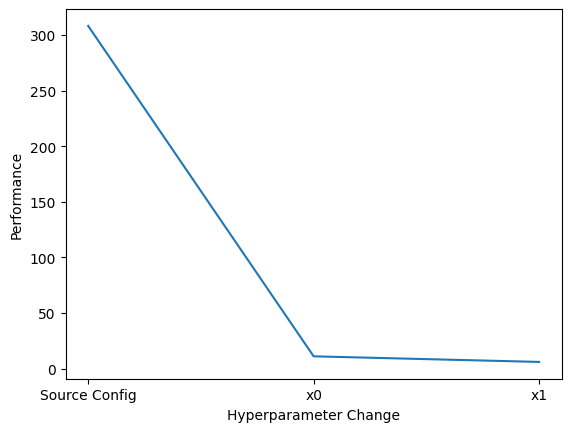

In [210]:
# We can see that the budget it uniform and that the history contains only four configurations across two hyperparameter values
# This is because the values are fixed in the target configuration and we only decide in which order to change them for best performance
# Visualized it looks like this:

from matplotlib import pyplot as plt

maximize = True
xs = [0, 1, 2]
ys = [runhistory["performance"][0], min(runhistory["performance"][1], runhistory["performance"][2]), runhistory["performance"][3]]

# In config 0, x1 is changed, so if this performance is better, x1 goes to the beginning of the path
if runhistory["performance"][0] < runhistory["performance"][1]:
    labels = ["Source Config", "x1", "x0"]
else:
    labels = ["Source Config", "x0", "x1"]

plt.figure()
plt.plot(xs, ys)
plt.xticks([0, 1, 2], labels)
plt.xlabel("Hyperparameter Change")
plt.ylabel("Performance")
plt.show()

In [211]:
# Let's implement a more general version that can handle any number of hyperparameters and any number of changes
import numpy as np

def df_to_config(configspace, row):
    config = configspace.sample_configuration()
    for key in row.keys():
        if key in config.keys():
            try:
                value = float(row[key])
            except:
                try:
                    value = int(row[key])
                except:
                    value = row[key]
            try:
                config[key] = value
            except:
                config[key] = value.item()
    return config

def plot_ablation_path(configspace, runhistory, source_config=None, maximize=False):
    done = False
    id = 0
    current_changes = 1
    ablation_path = {}
    ablation_path[1] = {"configs": [], "performances": []}
    if source_config is None:
        source_config = df_to_config(configspace, runhistory.loc[0])
        source_performance = runhistory.loc[0]["performance"]
        runhistory = runhistory.drop(0)
        id += 1
    while not done:
        performance = runhistory[runhistory["config_id"] == id]["performance"].item()
        config = df_to_config(configspace, runhistory.loc[runhistory["config_id"] == id])
        changes = 0
        for key in config.keys():
            if key in source_config.keys():
                if config[key] != source_config[key]:
                    changes += 1
        if changes > current_changes:
            current_changes = changes
            ablation_path[current_changes] = {"configs": [], "performances": []}
        ablation_path[current_changes]["configs"].append(config)
        ablation_path[current_changes]["performances"].append(performance)
        id += 1
        if id > max(runhistory["config_id"]):
            done = True

    xs = list(ablation_path.keys())
    # Plot the main path (most improvement first)
    if maximize:
        best_path_inds = [np.argmax(ablation_path[i]["performances"]) for i in xs]
    else:
        best_path_inds = [np.argmin(ablation_path[i]["performances"]) for i in xs]
    best_path_configs = [ablation_path[i]["configs"][ind] for i, ind in zip(xs, best_path_inds)]
    labels = []
    current_config = source_config
    for new_config in best_path_configs:
        for key in new_config.keys():
            if new_config[key] != current_config[key] and key not in labels:
                labels.append(key)


    best_path_ys = [source_performance] + [ablation_path[i]["performances"][ind] for i, ind in zip(xs, best_path_inds)]
    xs = [0] + xs
    plt.figure(figsize=(15, 5))
    plt.plot(xs, best_path_ys, linewidth=2)
    plt.xticks(xs, ["source"]+labels)
    plt.xticks(rotation=45)
    plt.xlabel("Hyperparameter Change")
    plt.ylabel("Performance")
    plt.show()

/var/folders/yc/_2wjgdhd4px91396bq5wm7kr0000gn/T/ipykernel_8353/1252775334.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  value = float(row[key])


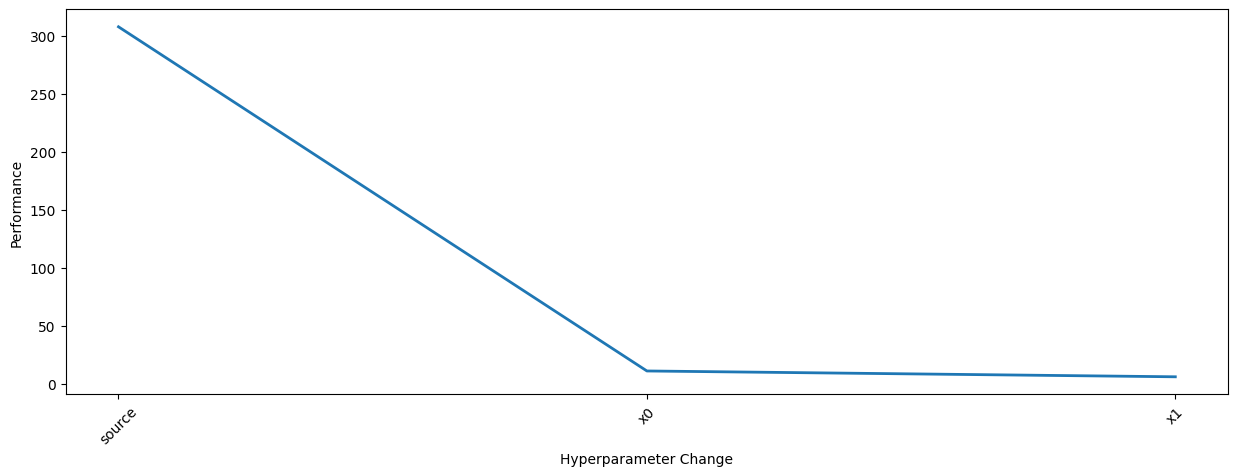

In [212]:
# To use this function, we need to specify a configspace
from ConfigSpace import ConfigurationSpace

configspace = ConfigurationSpace({"x0": (-10.0, 10.0), "x1": (-10.0, 10.0)})
plot_ablation_path(configspace, runhistory, maximize=False)

/var/folders/yc/_2wjgdhd4px91396bq5wm7kr0000gn/T/ipykernel_8353/1252775334.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  value = float(row[key])
/var/folders/yc/_2wjgdhd4px91396bq5wm7kr0000gn/T/ipykernel_8353/1252775334.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  value = int(row[key])


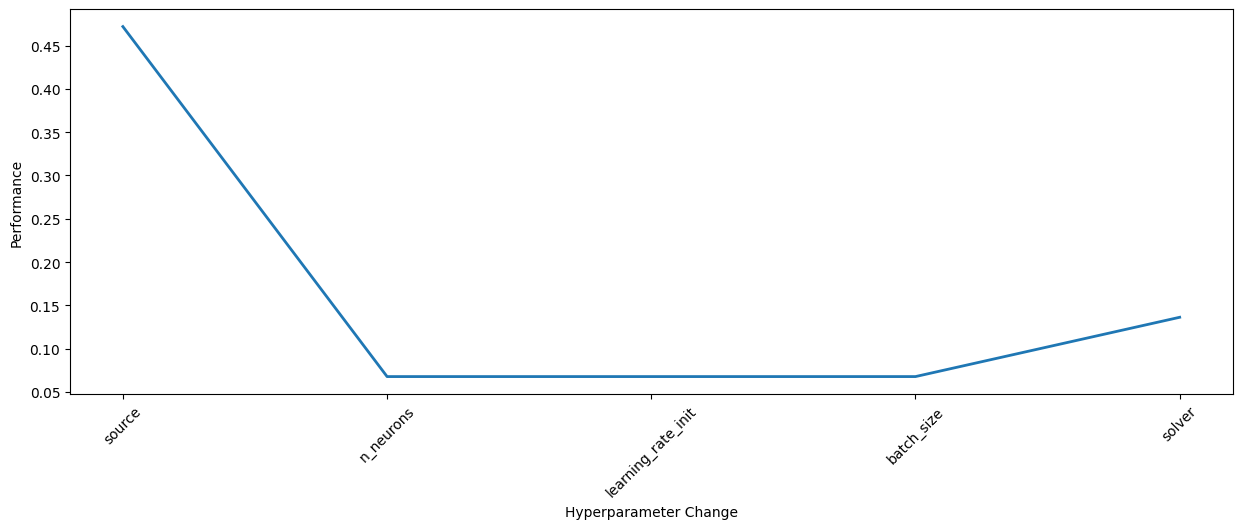

In [213]:
# And now a bit more complex. Here we can actually see that the target configuration is suboptimal!
configspace = ConfigurationSpace({"activation": ["logistic", "tanh", "relu"], "batch_size": (30, 300), "learning_rate": ["constant", "invscaling", "adaptive"], "learning_rate_init": (0.0001, 1.0), "n_layer": (1, 5), "n_neurons": (8, 1024), "solver": ["lbfgs", "sgd", "adam"]})
runhistory = pd.read_csv("example_ablation_paths/mlp/runhistory.csv")
plot_ablation_path(configspace, runhistory, maximize=False)